# Create Modelling Data for GAM
## Setup Jupyter Notebook

In [0]:
# Install the required packages - may need to restart the kernel after installation
!pip install pyxlsb

### Import packages

In [0]:
# Import external packages
import pandas as pd
import os
import numpy as np
import random
import pyarrow.parquet as pq
import shutil

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [0]:
# Import the internal package
import sys
package_loc = ""

# Add the package location to system paths
sys.path.append(package_loc)

from src import utility

### Define Paths

In [0]:
###########################################################################
###########################################################################

product = "DB"
model_type = "GAM"
path = f"{product}"

###########################################################################
###########################################################################

# Define the directories for input and output

dir_input = f"{path}/Input"
dir_export = f"{path}/{model_type}/Export"

print(os.listdir(dir_input))
print(os.listdir(dir_export))

['CMI Numerical Bands.xlsx', 'CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb']
['CMI DB Categorical Bands (with CalendarYear).xlsx', 'CMI DB Categorical Bands.xlsx', 'db_gam_modelling_data.parquet', 'db_gam_modelling_data_v2.parquet']


## Import Raw Data

In [0]:
###########################################################################
###########################################################################

data_dict = {
    "CY2016": "CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb",
    "CY2017": "CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb",
    "CY2018": "CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb",
    "CY2019": "CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb",
    "CY2020": "CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb",
}

unique_id = "unique_id"
holdout = "holdout"
fold = "random_fold"

###########################################################################
###########################################################################

df_data = utility.compile_data(
    data_dict, dir_input, unique_id=unique_id, holdout=holdout, fold=fold
)
df_data

In [0]:
# Check if there is any null value
df_data.isnull().sum()

ProductCategory         0
Gender                  0
SmokerStatus            0
DistributionChannel     0
CommencementYear        0
JointLifeStatus         0
SumAssuredBand          0
Age                     0
Duration                0
LivesExposure           0
AmountsExposure         0
IncurredClaims          0
AmountIncurred          0
ExpectedClaims          0
ExpectedAmountClaims    0
ComparatorTable         0
CalendarYear            0
unique_id               0
holdout                 0
random_fold             0
dtype: int64

In [0]:
# Check column types
df_data.dtypes

ProductCategory          object
Gender                   object
SmokerStatus             object
DistributionChannel      object
CommencementYear         object
JointLifeStatus          object
SumAssuredBand           object
Age                       int64
Duration                 object
LivesExposure           float64
AmountsExposure         float64
IncurredClaims          float64
AmountIncurred          float64
ExpectedClaims          float64
ExpectedAmountClaims    float64
ComparatorTable          object
CalendarYear             object
unique_id                 int64
holdout                   int64
random_fold               int64
dtype: object

## Sense Check Column Distributions

In [0]:
def make_pretty_pivot(styler, format_dict, caption, bar_dict):

    headers = {
        "selector": "th:not(.index_name)",
        "props": "background-color: #000066; color: white;",
    }

    styler.set_caption(caption)
    styler.format(format_dict)

    for col, color in bar_dict.items():
        styler.bar(color=color, subset=col, props="width: 5em;") 

    styler.set_table_styles(
        [
            {
                "selector": "caption",
                "props": [
                    ("font-weight", "bold"),
                    ("font-size", "100%"),
                    ("background-color", "#000066"),
                    ("color", "white"),
                ],
            },
            {"selector": "th", "props": "border: 1px solid white"},
            {
                "selector": "td",
                "props": "border: 1px solid #000066; text-align: center",
            },
            {"selector": "tr", "props": "border: 1px solid #000066"},
            {"selector": ".index_name", "props": "border: 1px solid #000066"},
            headers,
        ]
    )

    return styler

In [0]:
###################################################################
###################################################################

var1 = holdout
var2 = fold
target = "IncurredClaims"
weight = "LivesExposure"

mix = "mix"
freq = "actual"
bar_dict = {mix: "lightgreen", freq: "orange"}
caption = "Claim Frequency"

###################################################################
###################################################################

# Check that actual frequencies by random folds are similar
df_data_gb = df_data.groupby([var1, var2])[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]


format_dict = {
    freq: "{:,.4%}",
    mix: "{:,.2%}",
    target: "{:,.0f}",
    weight: "{:,.0f}",
}
df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

In [0]:
# Transform Duration into an ordinal variable
var = "Duration"
category_order = [*[str(x) for x in range(10)], "10+"]
df_data[var] = pd.Categorical(df_data[var], categories=category_order, ordered=True)

df_data_gb = df_data.groupby(var)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]

df_data_gb.style.pipe(lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict))

,LivesExposure,IncurredClaims,mix,actual
Duration,,,,
0,"4,113,773","1,642",11.35%,0.0399%
1,"3,663,973","2,467",10.11%,0.0673%
2,"3,213,466","2,842",8.87%,0.0884%
3,"2,884,806","3,217",7.96%,0.1115%
4,"2,630,577","3,241",7.26%,0.1232%
5,"2,355,861","3,191",6.50%,0.1354%
6,"2,182,373","3,179",6.02%,0.1457%
7,"1,984,901","3,143",5.48%,0.1583%
8,"1,797,171","2,982",4.96%,0.1659%


In [0]:
# Transform SumAssuredBand into an ordinal variable
category_order = [
    "£0-£25000",
    "£25001-£75000",
    "£75001-£125000",
    "£125001-£250000",
    "£250001+",
]

var = "SumAssuredBand"

df_data[var] = pd.Categorical(df_data[var], categories=category_order, ordered=True)

df_data_gb = df_data.groupby(var)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]
df_data_gb.style.pipe(lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict))

,LivesExposure,IncurredClaims,mix,actual
SumAssuredBand,,,,
£0-£25000,"2,513,809","10,088",6.94%,0.4013%
£25001-£75000,"6,930,909","13,565",19.12%,0.1957%
£75001-£125000,"9,242,826","10,975",25.50%,0.1187%
£125001-£250000,"12,238,301","9,637",33.77%,0.0787%
£250001+,"5,319,656","3,356",14.68%,0.0631%


In [0]:
###################################################################
###################################################################

var = "CommencementYear"

###################################################################
###################################################################

df_data_gb = df_data.groupby(var)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]
df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

,LivesExposure,IncurredClaims,mix,actual
CommencementYear,,,,
1999 or earlier,"650,398","1,515",1.79%,0.2330%
2000,"330,233",677,0.91%,0.2050%
2001,"713,202","1,514",1.97%,0.2123%
2002,"976,529","2,033",2.69%,0.2082%
2003,"1,272,213","2,651",3.51%,0.2084%
2004,"1,367,584","2,743",3.77%,0.2006%
2005,"1,209,695","2,312",3.34%,0.1911%
2006,"1,266,067","2,093",3.49%,0.1653%
2007,"1,417,840","2,330",3.91%,0.1644%


## Feature Engineering
### Numerical Features

In [0]:
# Transform Duration into a numerical variable 
df_data["Duration"] = df_data["Duration"].str.replace(r"\D", "", regex=True)
df_data["Duration"] = df_data["Duration"].astype(int)

v = "Duration"

df_data_gb = df_data.groupby(v)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]

df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

,LivesExposure,IncurredClaims,mix,actual
Duration,,,,
0,"4,113,773","1,642",11.35%,0.0399%
1,"3,663,973","2,467",10.11%,0.0673%
2,"3,213,466","2,842",8.87%,0.0884%
3,"2,884,806","3,217",7.96%,0.1115%
4,"2,630,577","3,241",7.26%,0.1232%
5,"2,355,861","3,191",6.50%,0.1354%
6,"2,182,373","3,179",6.02%,0.1457%
7,"1,984,901","3,143",5.48%,0.1583%
8,"1,797,171","2,982",4.96%,0.1659%


In [0]:
# Transform CommencementYear into a numerical variable 
df_data["CommencementYear"] = df_data["CommencementYear"].str.replace(r"\D", "", regex=True)
df_data["CommencementYear"] = df_data["CommencementYear"].astype(int)

v = "CommencementYear"

df_data_gb = df_data.groupby(v)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]

df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

,LivesExposure,IncurredClaims,mix,actual
CommencementYear,,,,
1999,"650,398","1,515",1.79%,0.2330%
2000,"330,233",677,0.91%,0.2050%
2001,"713,202","1,514",1.97%,0.2123%
2002,"976,529","2,033",2.69%,0.2082%
2003,"1,272,213","2,651",3.51%,0.2084%
2004,"1,367,584","2,743",3.77%,0.2006%
2005,"1,209,695","2,312",3.34%,0.1911%
2006,"1,266,067","2,093",3.49%,0.1653%
2007,"1,417,840","2,330",3.91%,0.1644%


In [0]:
# Transform SumAssuredBand into a numerical variable 

v = "SumAssuredBand"
sab_map = {"£0-£25000": 1, "£25001-£75000": 2, "£75001-£125000": 3, "£125001-£250000": 4, "£250001+": 5}
df_data["SumAssuredBand"] = df_data["SumAssuredBand"].map(sab_map)

# df_data[v] = pd.Categorical(df_data[v], categories=category_order, ordered=True)

df_data_gb = df_data.groupby(v)[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]

df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

,LivesExposure,IncurredClaims,mix,actual
SumAssuredBand,,,,
1,"2,513,809","10,088",6.94%,0.4013%
2,"6,930,909","13,565",19.12%,0.1957%
3,"9,242,826","10,975",25.50%,0.1187%
4,"12,238,301","9,637",33.77%,0.0787%
5,"5,319,656","3,356",14.68%,0.0631%


## Create Modelling Data
### Create bandings for numerical factors

In [0]:
num_feat = ["CommencementYear", "SumAssuredBand", "Age", "Duration"]

for v in num_feat:
    num_band = pd.read_excel(f"{dir_input}/CMI Numerical Bands.xlsx", sheet_name=v)
    band = list(
        set(num_band[~num_band["Lower Bound"].isnull()]["Lower Bound"].to_list())
    )
    band.sort()
    feat_max = max(band) * 2
    band = [*band, feat_max]
    l = list(range(1, len(band)))
    col_level = df_data[v].copy()
    col_level = pd.cut(col_level, bins=band, labels=l, right=False, include_lowest=True)
    col_level = col_level.astype(int)
    df_data[v + "_level"] = col_level
    
df_data

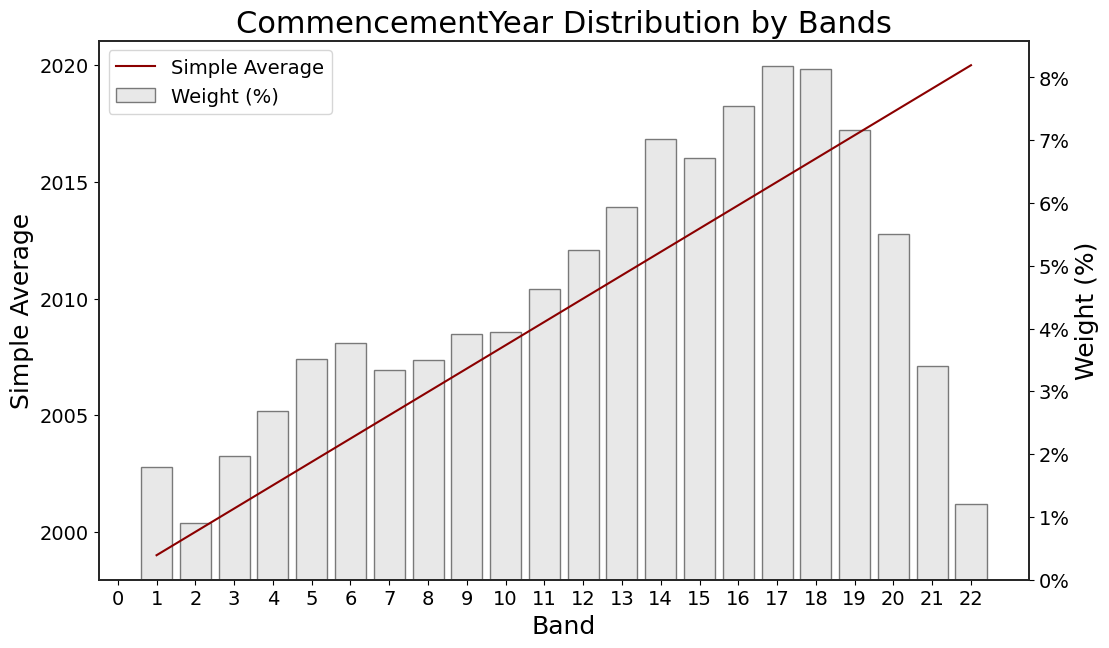

In [0]:
###################################################################
###################################################################

tick_fontsize = 14
label_fontsize = 18
title_fontsize = 22

v = "CommencementYear"
y1_label = "Simple Average"
y2_label = "Weight (%)"

###################################################################
###################################################################


# Check one variable to ensure that the GAM bandings are working as intended
df_data_gb = df_data.groupby([v + "_level"], dropna=False).agg(
    {v: "mean", weight: "sum"}
)

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

title = f"{v} Distribution by Bands"
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=df_data_gb[v],
    ax=ax,
    markers=True,
    label=y1_label,
    color="darkred",
)

leftylabel = y1_label
ax.set_ylabel(leftylabel, fontsize=label_fontsize)

# Set the primary y-tickers
ax_vals = ax.get_yticks()
r = 2 if max(ax_vals) < 3 else 0
ax_vals = np.unique(np.round(ax_vals, 0))
ax.yaxis.set_major_locator(mtick.FixedLocator(ax_vals))
leftyticklabels = [f"{x:.{r}f}" for x in ax_vals]
ax.set_yticklabels(leftyticklabels, fontsize=tick_fontsize)

# Set the x-axis tickers
min_index = df_data_gb.index.min() - 1
max_index = df_data_gb.index.max()
index_range = max_index - min_index

if index_range <= 25:
    step = 1
elif index_range <= 50:
    step = 5
elif index_range <= 100:
    step = 10
else:
    step = 20

tick_positions = np.arange(min_index, max_index + step, step)
tick_labels = [f"{x:.0f}" for x in tick_positions]

ax.xaxis.set_major_locator(mtick.FixedLocator(tick_positions))
ax.set_xticklabels(tick_labels, fontsize=tick_fontsize)

ax.set_xlabel(
    f"Band",
    fontsize=label_fontsize,
)

# Convert weight to %
df_data_gb[weight] /= df_data_gb[weight].sum()

ax1 = ax.twinx()
ax1.bar(
    df_data_gb.index,
    df_data_gb[weight],
    color="lightgray",
    alpha=0.5,
    ec="k",
    label=y2_label,
)

# Format secondary y-axis tickers
vals = ax1.get_yticks()
min_vals = min(vals)
max_vals = max(vals)
vals_range = max_vals - min_vals

if vals_range > 0.05:
    dp = 0
elif vals_range >= 0.02 and vals_range <= 0.05:
    dp = 1
elif vals_range >= 0.01 and vals_range < 0.02:
    dp = 2
else:
    dp = 3
rightyticklabels = [f"{x*100:.{dp}f}%" for x in vals]
ax1.yaxis.set_major_locator(mtick.FixedLocator(vals))
ax1.set_yticklabels(rightyticklabels, fontsize=tick_fontsize)
ax1.set_ylabel(y2_label, fontsize=label_fontsize)

# Combine legends
lines, labels = ax.get_legend_handles_labels()
bars, bar_labels = ax1.get_legend_handles_labels()
ax.legend(lines + bars, labels + bar_labels, loc="best", fontsize=tick_fontsize)

title = f"{v} Distribution by Bands"
ax.set_title(title, fontsize=title_fontsize)

# Align the order of different layers
ax.set_zorder(2)
ax.patch.set_alpha(0)
ax1.set_zorder(1)

[Text(0.5, 0, 'CommencementYear'),
 Text(1.5, 0, 'SumAssuredBand'),
 Text(2.5, 0, 'Age'),
 Text(3.5, 0, 'Duration')]

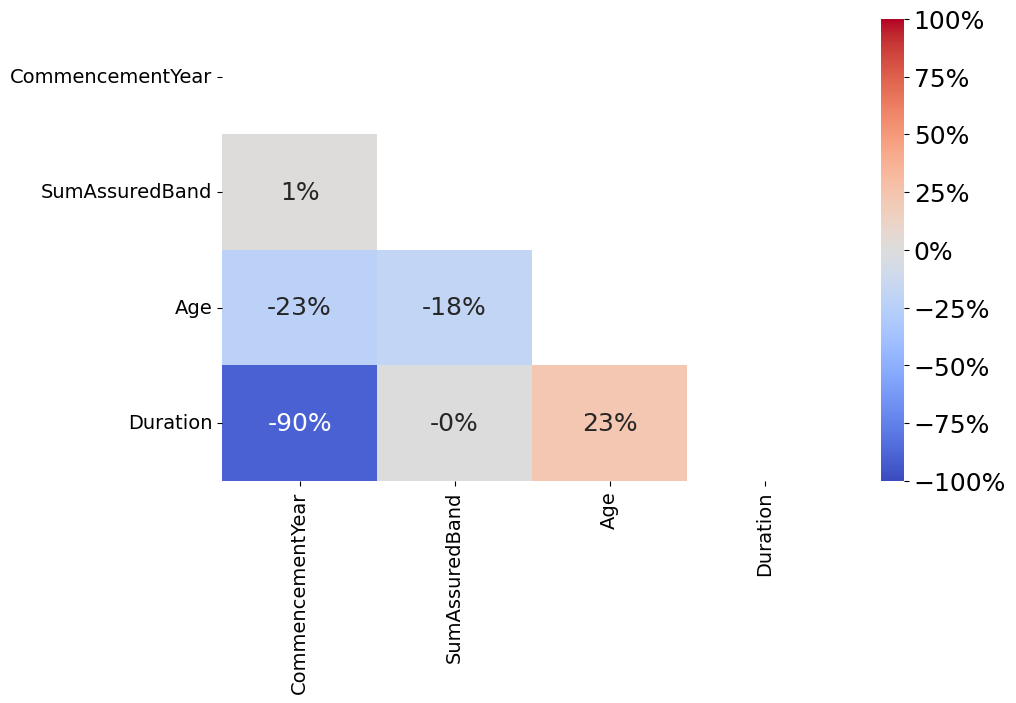

In [0]:
# Check correlations between numerical variables 
num_list = [x + "_level" for x in num_feat]
corr_mat = round(df_data[num_list].corr(), 2)

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_mat[mask] = np.nan

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(
    corr_mat,
    annot=True,
    annot_kws={"size": label_fontsize},
    fmt=".0%",
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
)

colorbar = ax.collections[0].colorbar 
colorbar.ax.tick_params(labelsize=label_fontsize) 
colorbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax.set_facecolor("white")
ax.set_yticklabels(df_data[num_feat].columns, fontsize=tick_fontsize)
ax.set_xticklabels(df_data[num_feat].columns, fontsize=tick_fontsize)

### Map categorical levels to integer values

In [0]:
# Define a list of categorical variables
cat_feat = [
    "ProductCategory",
    "Gender",
    "SmokerStatus",
    "DistributionChannel",
    "JointLifeStatus",
    "CalendarYear"
]

# Create categorical bandings for the first variable
v = cat_feat[0]
df_ = pd.DataFrame(df_data[v].unique(), columns=["Categorical_Level"])
df_.sort_values("Categorical_Level", inplace=True)
df_["Integer_Value"] = list(range(len(df_)))

df_data[v + "_cat_level"] = df_data[v].map(
    df_.set_index("Categorical_Level").to_dict()["Integer_Value"]
)

# Save down the categorical bandings
with pd.ExcelWriter(
    "/tmp/CMI Categorical Bands (with CalendarYear).xlsx", engine="openpyxl", mode="w"
) as writer:
    df_.to_excel(writer, sheet_name=v, index=False)

for v in cat_feat[1:]: 
    df_ = pd.DataFrame(df_data[v].unique(), columns=["Categorical_Level"])
    df_.sort_values("Categorical_Level", inplace=True)
    df_["Integer_Value"] = list(range(len(df_)))

    df_data[v + "_cat_level"] = df_data[v].map(
        df_.set_index("Categorical_Level").to_dict()["Integer_Value"]
    )

    with pd.ExcelWriter(
        "/tmp/CMI Categorical Bands (with CalendarYear).xlsx", engine="openpyxl", mode="a"
    ) as writer:
        df_.to_excel(writer, sheet_name=v, index=False)

In [0]:
###################################################################
###################################################################

# Check the distribution of one categorical variable
v = "CalendarYear"

###################################################################
###################################################################

df_data_gb = df_data.groupby([v, v + "_cat_level"])[[weight, target]].sum()
df_data_gb[mix] = df_data_gb[weight] / df_data_gb[weight].sum()
df_data_gb[freq] = df_data_gb[target] / df_data_gb[weight]
df_data_gb.sort_values(freq, inplace=True)

df_data_gb.style.pipe(
    lambda x: make_pretty_pivot(x, format_dict, caption, bar_dict)
)

,,LivesExposure,IncurredClaims,mix,actual
CalendarYear,CalendarYear_cat_level,,,,
CY2016,0,"6,818,697","8,638",18.81%,0.1267%
CY2017,1,"7,044,035","8,938",19.43%,0.1269%
CY2018,2,"7,273,102","9,319",20.07%,0.1281%
CY2019,3,"7,460,428","9,629",20.58%,0.1291%
CY2020,4,"7,649,238","11,097",21.10%,0.1451%


## Export files

In [0]:
shutil.copyfile(
    "/tmp/CMI Categorical Bands (with CalendarYear).xlsx",
    f"{dir_export}/CMI {product} Categorical Bands (with CalendarYear).xlsx",
)

In [0]:
###########################################################################
###########################################################################

data_version = "v2"

###########################################################################
###########################################################################

df_data.set_index(unique_id).to_parquet(
    f"{dir_export}/{product.lower()}_gam_modelling_data_{data_version}.parquet",
    engine="pyarrow",
    compression="gzip",
)